# Preliminary Data Exploration and Mapping of OCO2 Data
#### NOTE: If you have maps generated in this notebook, it will run very slowly. I advise you clear the outputs when done

In [19]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import requests
import json


import matplotlib.pyplot as plt
import plotly.express as px
import plotly

import geopandas as gpd

#BASEMAP
import mpl_toolkits
import seaborn as sns; sns.set()
import datetime as dt


## Read in a CSV created in NASA_data_gather.ipynb

In [20]:
#This file is read from a local source because it was too large to upload to github
df_xco2_base= pd.read_csv(r"C:\Users\ddrye\OneDrive\Documents\OMSA_Program\OMSA 2023\Summer2023\Practicum\off_git\data\OCO2_BASE_2014-2023_V1.csv")

## Overview for 2016, 2017 and 2018 data

In [21]:

sedac_years=df_xco2_base[df_xco2_base['Year'].isin([2016,2017,2018])]

print("non filtered shape:",sedac_years.shape)

#filtering on good quality data
sedac_years_filtered=sedac_years[sedac_years["xco2_quality_flag"]==0]

#dropping the unnamed column - just a redundant index column.
sedac_years_filtered=sedac_years_filtered.drop(["Unnamed: 0"],axis=1)

#getting the filtered shape of the data
print("filtered shape:",sedac_years_filtered.shape)

#getting a look at the data
display(sedac_years_filtered.head())
display(sedac_years_filtered.tail())

#checking for NA values
if sedac_years_filtered[sedac_years_filtered.isna().any(axis=1)].empty==True:
    print("No NAs")
else:
    print("NAs Present")
    display(sedac_years_filtered[sedac_years_filtered.isna().any(axis=1)])

#getting an overview of the xco2 readings
print("\n xco2 readings:")
display(sedac_years_filtered.xco2.describe())

#getting the average co2 reading accross all years
xco2_max=sedac_years_filtered['xco2'].max()
print(xco2_max)
print(sedac_years_filtered.query('xco2 == xco2.max()'))

non filtered shape: (5196522, 12)
filtered shape: (3614699, 11)


,county_name,state_name,geoid,DateTime,Year,Month,Day,Latitude,Longitude,xco2,xco2_quality_flag
2210675,Morgan,Ohio,39115,2016-01-01 18:20:55.740,2016,1,1,39.565636,-81.736570,396.17938,0
2210684,Muskingum,Ohio,39119,2016-01-01 18:20:59.720,2016,1,1,39.803432,-81.854515,398.18756,0
2210732,Hutchinson,Texas,48233,2016-01-01 19:57:01.330,2016,1,1,35.687325,-101.207830,399.39062,0
2210736,Hutchinson,Texas,48233,2016-01-01 19:57:01.720,2016,1,1,35.714104,-101.222600,407.44168,0
2210744,Hutchinson,Texas,48233,2016-01-01 19:57:02.020,2016,1,1,35.734060,-101.228400,405.87845,0


,county_name,state_name,geoid,DateTime,Year,Month,Day,Latitude,Longitude,xco2,xco2_quality_flag
7407160,Union,New Mexico,35059,2018-12-31 20:04:08.380,2018,12,31,36.740005,-103.15593,408.55994,0
7407162,Union,New Mexico,35059,2018-12-31 20:04:08.770,2018,12,31,36.767025,-103.17053,408.05670,0
7407163,Union,New Mexico,35059,2018-12-31 20:04:08.780,2018,12,31,36.760002,-103.16180,409.73070,0
7407165,Union,New Mexico,35059,2018-12-31 20:04:09.080,2018,12,31,36.780000,-103.16766,408.75687,0
7407171,Las Animas,Colorado,8071,2018-12-31 20:04:12.340,2018,12,31,37.007607,-103.26176,407.10162,0


No NAs

 xco2 readings:


count    3.614699e+06
mean     4.052818e+02
std      3.172027e+00
min      3.755183e+02
25%      4.032649e+02
50%      4.053651e+02
75%      4.075717e+02
max      4.186206e+02
Name: xco2, dtype: float64

418.6206
        county_name state_name  geoid                 DateTime  Year  Month  \
6119815      Elmore      Idaho  16039  2018-05-08 20:37:48.070  2018      5   

         Day   Latitude   Longitude      xco2  xco2_quality_flag  
6119815    8  43.667072 -115.477394  418.6206                  0  


## Overview for all of the years

In [22]:
#df_xco2_base= pd.read_csv(r"C:\Users\ddrye\OneDrive\Documents\OMSA_Program\OMSA 2023\Summer2023\Practicum\off_git\data\OCO2_BASE_2014-2023_V1.csv")
print("non filtered shape:",df_xco2_base.shape)

#filtering on good quality data
df_xco2_base_filtered=df_xco2_base[df_xco2_base["xco2_quality_flag"]==0]

#dropping the unnamed column - just a redundant index column and the total_delta column - poor naming on my part 
df_xco2_base_filtered=df_xco2_base_filtered.drop(["Unnamed: 0"],axis=1)

#getting the filtered shape of the data
print("filtered shape:",df_xco2_base_filtered.shape)

#getting a look at the data
display(df_xco2_base_filtered.head())
display(df_xco2_base_filtered.tail())

#checking for NA values
if df_xco2_base_filtered[df_xco2_base_filtered.isna().any(axis=1)].empty==True:
    print("No NAs")
else:
    print("NAs Present")
    display(df_xco2_base_filtered[df_xco2_base_filtered.isna().any(axis=1)])

#getting an overview of the xco2 readings
print("\n xco2 readings:")
display(df_xco2_base_filtered.xco2.describe())

#getting the average co2 reading accross all years
xco2_max=df_xco2_base_filtered['xco2'].max()
print(xco2_max)
print(df_xco2_base_filtered.query('xco2 == xco2.max()'))



non filtered shape: (14960035, 12)
filtered shape: (10328595, 11)


,county_name,state_name,geoid,DateTime,Year,Month,Day,Latitude,Longitude,xco2,xco2_quality_flag
8,Moore,North Carolina,37125,2014-09-06 18:30:54.060,2014,9,6,35.265804,-79.52109,395.67447,0
9,Moore,North Carolina,37125,2014-09-06 18:30:54.070,2014,9,6,35.260723,-79.51034,395.76440,0
24,Randolph,North Carolina,37151,2014-09-06 18:30:59.060,2014,9,6,35.565514,-79.60734,396.62753,0
29,Randolph,North Carolina,37151,2014-09-06 18:31:01.020,2014,9,6,35.704697,-79.68605,394.24118,0
32,Randolph,North Carolina,37151,2014-09-06 18:31:01.320,2014,9,6,35.724680,-79.69178,396.93200,0


,county_name,state_name,geoid,DateTime,Year,Month,Day,Latitude,Longitude,xco2,xco2_quality_flag
14959804,Madera,California,6039,2023-03-31 21:00:31.360,2023,3,31,37.267506,-119.54923,419.50134,0
14959805,Madera,California,6039,2023-03-31 21:00:31.370,2023,3,31,37.256123,-119.54236,415.96200,0
14959806,Madera,California,6039,2023-03-31 21:00:31.380,2023,3,31,37.245940,-119.53481,418.09354,0
14959965,Kodiak Island,Alaska,2150,2023-03-31 22:45:53.710,2023,3,31,57.966873,-154.98221,422.19824,0
14959966,Kodiak Island,Alaska,2150,2023-03-31 22:45:53.720,2023,3,31,57.957138,-154.96135,422.61580,0


No NAs

 xco2 readings:


count    1.032860e+07
mean     4.088636e+02
std      6.777812e+00
min      3.640129e+02
25%      4.036820e+02
50%      4.090567e+02
75%      4.143601e+02
max      4.309673e+02
Name: xco2, dtype: float64

430.96732
         county_name state_name  geoid                 DateTime  Year  Month  \
14915350        Lake    Montana  30047  2023-03-19 20:38:05.760  2023      3   

          Day  Latitude  Longitude       xco2  xco2_quality_flag  
14915350   19  47.83149 -114.46876  430.96732                  0  


## Groupings for Visualization - FOR ALL YEARS

In [23]:
#A function that makes grouping by a little easier
def overview(df,groupby=[]):
    counts=df.groupby(groupby, as_index=False)["xco2"].size().rename(columns={'size':'readings_count'})
    xco2_avg=df.groupby(groupby, as_index=False)["xco2"].mean().rename(columns={'xco2':'avg_xco2'})
    xco2_min=df.groupby(groupby, as_index=False)["xco2"].max().rename(columns={'xco2':'max_xco2'})
    xco2_max=df.groupby(groupby, as_index=False)["xco2"].min().rename(columns={'xco2':'min_xco2'})
    std_deviation=df.groupby(groupby, as_index=False)["xco2"].std().rename(columns={'xco2':'stddev_xco2'})

    combined=pd.merge(counts, xco2_avg, on=groupby)
    combined=pd.merge(combined, std_deviation, on=groupby)
    combined=pd.merge(combined, xco2_min, on=groupby)
    combined=pd.merge(combined, xco2_max, on=groupby)

    if 'geoid' in groupby:
        combined = combined.astype({'geoid':'string'})
        combined["geoid"] = combined["geoid"].str.zfill(5)
    
    return combined


#Group by state and year
state_ov=overview(df_xco2_base_filtered,groupby=["state_name","Year"])
display(state_ov.head())

#Group by county_name and geoid - some countys may have the same name, thats why we're doing geoid as well
county_ov=overview(df_xco2_base_filtered,groupby=["county_name","geoid"])
display(county_ov.head())


,state_name,Year,readings_count,avg_xco2,stddev_xco2,max_xco2,min_xco2
0,Alabama,2014,5167,397.956121,1.292607,403.21558,392.51740
1,Alabama,2015,7137,400.441741,2.172642,406.23400,392.63812
2,Alabama,2016,18907,403.579653,1.358911,409.03973,394.93478
3,Alabama,2017,5386,406.782090,1.537323,410.62488,398.04170
4,Alabama,2018,11963,408.360145,1.882931,413.21167,397.96750


,county_name,geoid,readings_count,avg_xco2,stddev_xco2,max_xco2,min_xco2
0,Abbeville,45001,2002,406.524325,5.504219,419.12167,388.80200
1,Acadia,22001,902,408.219579,5.856997,417.04156,395.61450
2,Accomack,51001,2806,407.983413,6.855773,422.42288,392.36475
3,Ada,16001,5233,408.745287,7.036336,424.73750,392.86750
4,Adair,19001,296,405.080846,7.959032,419.41406,393.69278


## Plotting


C:\Users\ddrye\AppData\Local\Temp\ipykernel_22728\794561854.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



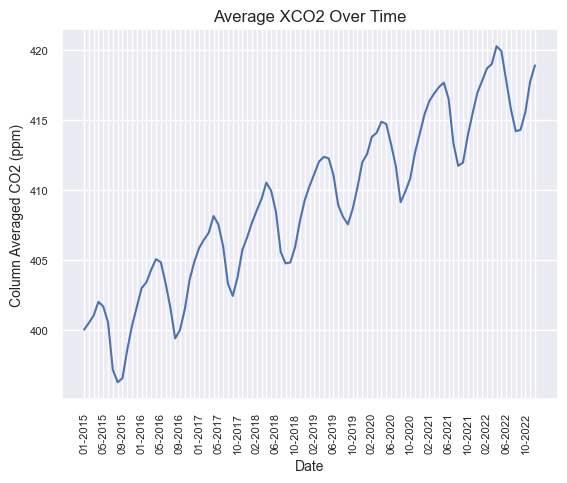

In [24]:
#Group by year and month
month_year_ov=overview(df_xco2_base_filtered,groupby=["Year",'Month'])

#setting the year range for 2015 through 2022
month_year_ov = month_year_ov.loc[(month_year_ov['Year'] < 2023) & (month_year_ov['Year'] > 2014) ]

#creating a datetime column from month and year
month_year_ov['Date']=month_year_ov['Month'].map(str) + '-' + month_year_ov['Year'].map(str)
month_year_ov['Date'] = pd.to_datetime(month_year_ov['Date']).dt.strftime('%m-%Y')
#display(month_year_ov.head())

#plotting
a= sns.lineplot(x='Date', y='avg_xco2', data=month_year_ov)
a.set(title='Average XCO2 Over Time')
a.set_ylabel("Column Averaged CO2 (ppm)",fontsize=15)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Column Averaged CO2 (ppm)', fontsize=10)
plt.tick_params(axis='x', which='major', labelsize=8, rotation=90)
plt.tick_params(axis='y', which='major', labelsize=8)
for index, label in enumerate(a.get_xticklabels()):
   if index % 4 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

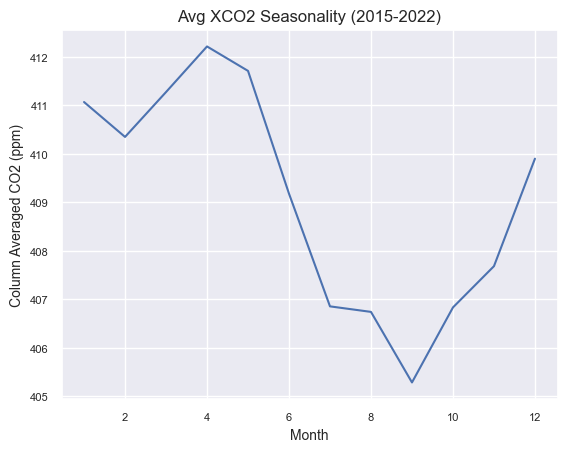

In [25]:
#Seasonality - USING ALL YEARS
seasonal_ov=overview(df_xco2_base_filtered,groupby=["Month"])

#plotting
b= sns.lineplot(x='Month', y='avg_xco2', data=seasonal_ov)
b.set(title='Avg XCO2 Seasonality (2015-2022)')
#a.set_xlabel("Month",fontsize=15)
b.set_ylabel("Column Averaged CO2 (ppm)",fontsize=15)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Column Averaged CO2 (ppm)', fontsize=10)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tick_params(axis='y', which='major', labelsize=8)


# Mapping

#### Getting the county polygons for visualization on map

In [26]:
request = urllib.request.Request('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
opener = urllib.request.build_opener()
response = opener.open(request)
counties_map = json.load(response)

#### Mapping County Average XCO2 from year to year

In [ ]:
#Year State and County for all years
df_xco2_base_filtered_years=df_xco2_base_filtered[df_xco2_base_filtered['Year'].isin([2015,2016,2017,2018,2019,2020,2021,2022])]
ysc_ov=overview(df_xco2_base_filtered_years,groupby=['geoid',"county_name","Year"])
ysc_ov['Date'] = pd.to_datetime(ysc_ov['Year'].map(str)).dt.strftime('%Y')
ysc_ov.sort_values(by='Date', inplace=True)
ysc_ov.rename(columns={'avg_xco2':'XCO2 (ppm)'}, inplace=True)


fig = px.choropleth(ysc_ov, geojson=counties_map, locations='geoid', color='XCO2 (ppm)',
                           color_continuous_scale="Viridis",
                           animation_frame='Date',
                           hover_data=['readings_count','county_name'],
                           scope="usa",
                           range_color=(390,420),
                           width=800,
                           height=600,
                           )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},legend_title="CO2 ppm")
fig.show()

#### Mapping Average XCO2 over all Years

In [ ]:
#County for 2015-2018
df_xco2_base_filtered_years=df_xco2_base_filtered[df_xco2_base_filtered['Year'].isin([2016,2017,2018])]
c_ov=overview(df_xco2_base_filtered_years,groupby=['geoid',"county_name"])

#plotting
fig = px.choropleth(c_ov, geojson=counties_map, locations='geoid', color='avg_xco2',
                           color_continuous_scale="Viridis",
                           hover_data=['readings_count','county_name'],
                           scope="usa",
                           range_color=(400,405),
                           width=800,
                           height=600
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Mapping percent change from year to year for all years

In [ ]:
#County percent change from year to year
df_xco2_base_filtered_allyears=df_xco2_base_filtered[df_xco2_base_filtered['Year'].isin([2015,2016,2017,2018,2019,2020,2021,2022])]
cypct_ov=overview(df_xco2_base_filtered_allyears,groupby=['geoid',"county_name",'Year'])
pct_change = (cypct_ov.groupby('geoid')['avg_xco2']
                                  .apply(pd.Series.pct_change) + 1).rename('pct_change').reset_index()
cypct_ov=pd.merge(cypct_ov, pct_change['pct_change'], left_index=True, right_index=True)
cypct_ov['Date'] = pd.to_datetime(cypct_ov['Year'].map(str)).dt.strftime('%Y')


fig = px.choropleth(cypct_ov, geojson=counties_map, locations='geoid', color='pct_change',
                           color_continuous_scale="Viridis",
                           hover_data=['readings_count','county_name'],
                           scope="usa",
                           animation_frame='Date',
                           range_color=(1.00,1.025),
                           width=800,
                           height=600
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

#### Mapping percent increase from 2016 to 2018

In [ ]:
#County percent change from 2016 to 2018
df_xco2_base_filtered_years=df_xco2_base_filtered[df_xco2_base_filtered['Year'].isin([2016,2018])]
cpct_ov=overview(df_xco2_base_filtered_years,groupby=['geoid',"county_name",'Year'])
pct_change = (cpct_ov.groupby('geoid')['avg_xco2']
                                  .apply(pd.Series.pct_change) + 1).rename('pct_change').reset_index()
cpct_ov=pd.merge(cpct_ov, pct_change['pct_change'], left_index=True, right_index=True)
cpct_ov=cpct_ov[cpct_ov['Year']==2018]

#plotting
fig = px.choropleth(cpct_ov, geojson=counties_map, locations='geoid', color='pct_change',
                           color_continuous_scale="YlOrRd",
                           hover_data=['readings_count','county_name'],
                           scope="usa",
                           range_color=(1.0,1.025),
                           width=800,
                           height=600
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()